# Rocket Dynamics

We are interested in modelling the dynamics of a water rocket travelling horizontally along a track.

This notebook is available at https://github.com/jameskermode/rocket


In [3]:
using PyPlot
rc("lines", linewidth=2)
rc("font", size=14)

## Parameters

In [7]:
dt = 0.001 # timestep, s
N = 1500 #  number of steps
m0 = 0.500 # empty mass, kg
A = 7.0e-3 # silhouette area, m^2
Cd = 1.0 # drag coefficient
rho_a = 1.2 # air density kg/m^3
P_a = 1e5 # air pressure, N/m^2
rho_w = 1000.0 # water density, kg/m^3
V_t = 6.0e-4 # tank volume, m^3
f = 0.3 # fill fraction
D_n = 6e-3 # nozzle diameter, m
P_l = 3e5 # launch pressure, N/m^2
D_t = 6.7e-2 # tank diameter, m
mu = 5e-2 # rolling friction
g = 9.81 # acceleration due to gravity, m/s^2
gamma = 1.4 # ratio of heat capacities Cp/Cv
vertical = false # if true, rocket travels vertically against gravity

a_threshold = 0.5 # threshold acceleration for detecting launch, m/s^2
t_max = 6.0 # maxmimum time to take from experimental data, s
nothing

## Numerical Integration of the differential equation

We discriteze time in small steps $\Delta t$ and compute: 
  1. the pressure in the tank $P_t$ from adiabatic gas expansion law ($pV^\gamma =$ constant)
  2. the exhaust velocity $v_e$, from Bernoulli's equation and conservation of the volume rate of flow ($A_1 v_1 = A_2 v_2$)
  3. volume flow rate $dV/dt = v_e A_n$ where $A_n$ is the nozzle area
  3. mass flow rate $dm/dt = \rho_w dV/dt$ where $\rho_w$ is the density of water
  4. remaining total mass, and volumes of water and air
  5. forward thrust force due to ejection of fuel $F_t = v_e dm/dt$
  6. drag force $F_d = \frac{1}{2}C_d\rho_a*v^2$
  7. frictional rolling resistance $F_r = \mu mg$ or gravity $F_g = mg$, depending on orientation of rocket

Finally, we update the acceleration, velocity and position using the total force $F = F_t - F_d - F_r$

In [4]:
function run_model()    
    t = collect(0:dt:N*dt)
    x = zeros(N+1)
    v = zeros(N+1)
    a = zeros(N+1)

    P_t = zeros(N+1)
    P_t[1] = P_l
    v_e = zeros(N+1)

    A_n = pi*(D_n/2)^2 # nozzle area, m^2
    A_t = pi*(D_t/2)^2 # tank area, m^2
    area_ratio = A_n/A_t
    V_w = f*V_t
    V_a = (1-f)*V_t

    for n = 1:N
        # Verlet integration of the positions
        x[n+1] = x[n] + v[n]*dt + 0.5*a[n]*dt^2

        # pressure in the tank, from adiabatic gas expansion
        if V_w <= 0.0
            P_t[n+1] = P_a
        else
            P_t[n+1] = P_l*(V_t*(1-f)/V_a^gamma)
        end

        # exhaust velocity, from Bernoulli
        v_e[n+1] = sqrt((P_t[n+1] - P_a)/(rho_w*(1 - area_ratio^2)))
        dV_dt = v_e[n+1]*A_n
        dm_dt = dV_dt*rho_w

        # update volumes of water and air in tank
        V_w = V_w - dV_dt*dt
        V_a = V_t - V_w

        m = m0 + V_w*rho_w # remaining total mass

        F_thrust = v_e[n+1]*dm_dt
        F_drag = - 0.5*A*Cd*rho_a*v[n]^2*sign(v[n]) # drag opposes motion
        if (vertical)
            F_ext = - m*g # gravity opposes motion
        else
            F_ext = - mu*m*g # friction opposes motion
        end
        F_total = F_thrust + F_drag + F_ext

        # acceleration = force/massa
        a[n+1] = F_total/m

        # update velocities with Verlet algorithm
        v[n+1] = v[n] + (a[n+1] + a[n])/2*dt
    end

    subplot(313)
    plot(t,x)
    xlim(0,N*dt)
    xlabel("Time / s")
    ylabel("Position / m")
    axhline(0; color="k", linestyle="dashed", label="_nolegend_")

    subplot(312)
    plot(t,v)
    ylabel("Velocity / m/s")
    xlim(0,N*dt)
    axhline(0; color="k", linestyle="dashed", label="_nolegend_")

    subplot(311)
    plot(t,a)
    ylabel("Accel / m/s^2")
    xlim(0,N*dt)
    axhline(0; color="k", linestyle="dashed", label="_nolegend_")

    (x, v, a)
end

run_model (generic function with 1 method)

## Simulating varying water filling fraction

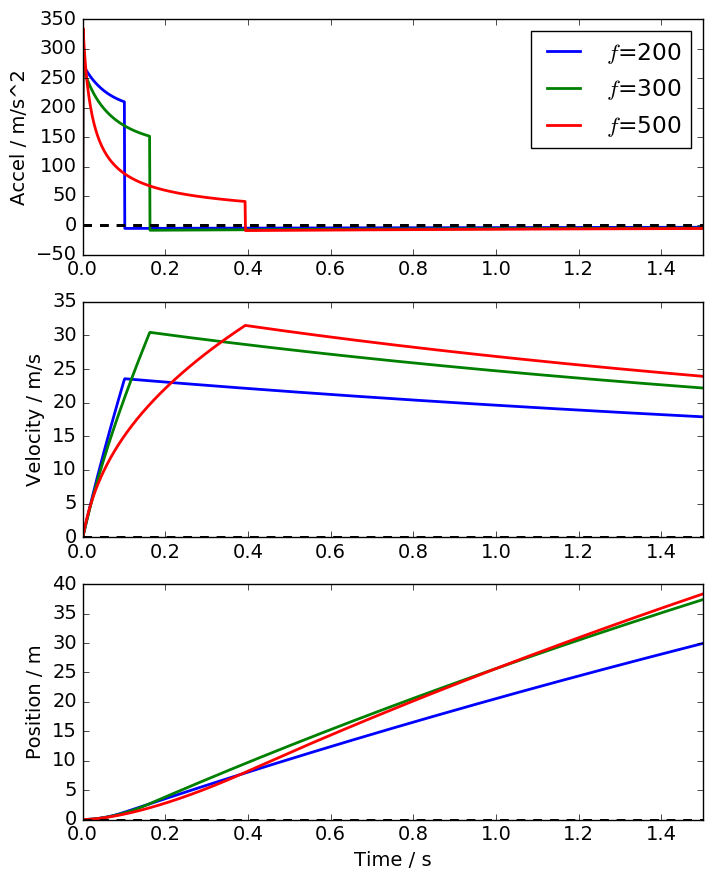

PyObject <matplotlib.legend.Legend object at 0x31fc58e50>

In [6]:
figure(figsize=(8,10))

f = 200/600
x1, v1, a1 = run_model()

f = 300/600
x2, v2, a2 = run_model()

f = 500/600
x3, v3, a3 = run_model()

legend([L"$f$=200"; L"$f$=300"; L"$f$=500"])

## Varying nozzle diameter

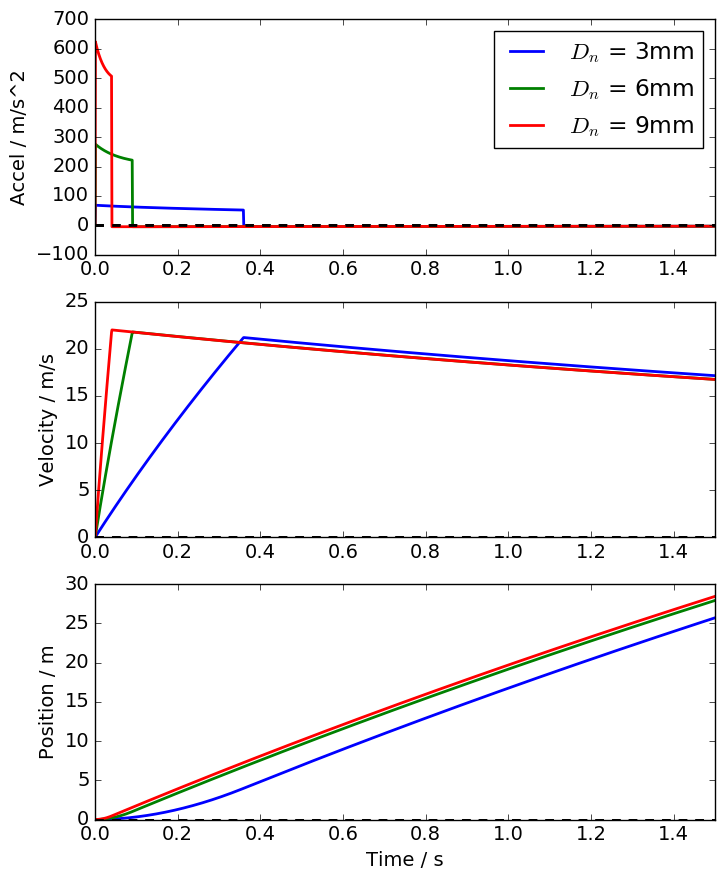

PyObject <matplotlib.legend.Legend object at 0x320be0f90>

In [7]:
figure(figsize=(8,10))

f = 0.3 # back to original 30% filling

D_n = 3e-3
run_model()

D_n = 6e-3
run_model()

D_n = 9e-3
run_model()

legend([L"$D_n$ = 3mm"; L"$D_n$ = 6mm"; L"$D_n$ = 9mm"])

## Data Analysis - calibration of accelerometer

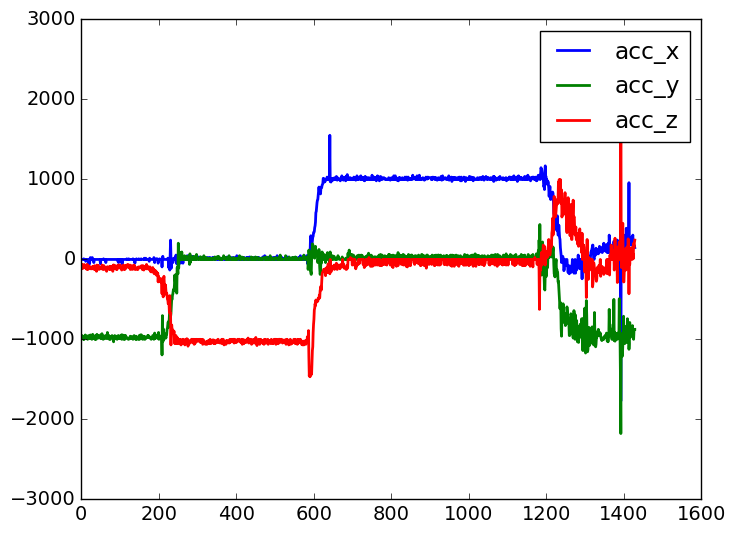

PyObject <matplotlib.legend.Legend object at 0x31a820b10>

In [5]:
using DataFrames
caldata = readtable("CALIBRATION.CSV")
plot(caldata[:X_mm_s_2_])
plot(caldata[:Y_mm_s_2_])
plot(caldata[:Z_mm_s_2_])
legend(["acc_x", "acc_y", "acc_z"])

In [10]:
g1 = mean(abs(caldata[:Y_mm_s_2_][1:200]))
g2 = mean(abs(caldata[:Z_mm_s_2_][250:500]))
g3 = mean(abs(caldata[:X_mm_s_2_][700:1110]))

acc_conv = g/mean([g1, g2, g3])
t_conv = 1e-3

0.001

## Rocket accelerometer data

DAT_1.CSV
DAT_2.CSV
DAT_3.CSV


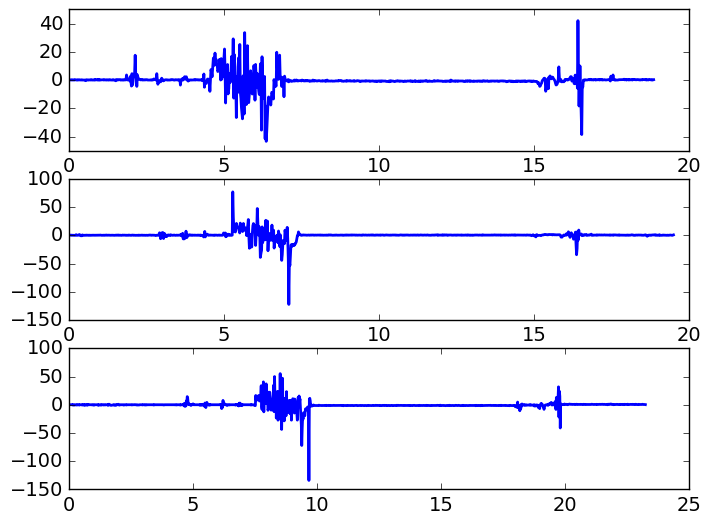

In [11]:
fns = filter(r"DAT_.*\.CSV", readdir())
for (i, fn) in enumerate(fns)
    println(fn)    
    data = readtable(fn)
    subplot(length(fns),1,i)
    plot(data[:Time_ms_]*t_conv, data[:X_mm_s_2_]*acc_conv)
end

## Smoothing the data with a Kalman filter

DAT_1.CSV
DAT_2.CSV
DAT_3.CSV


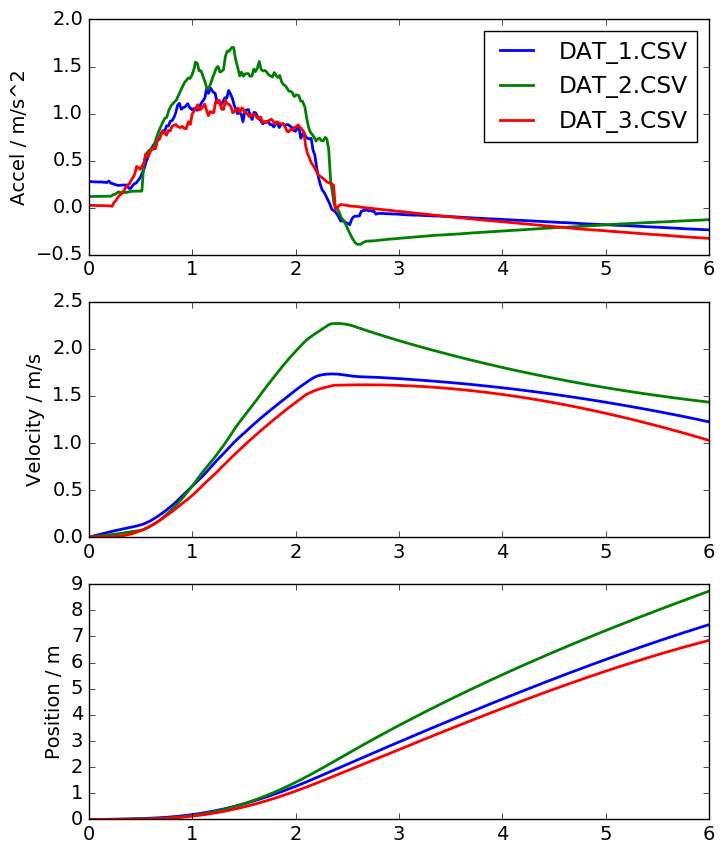

PyObject <matplotlib.legend.Legend object at 0x31c215510>

In [13]:
include("kalman.jl")

peak_a = Dict()
peak_v = Dict()

figure(figsize=(8,10))
for fn in fns
    println(fn)

    # extract t and accel data and convert to SI units
    data = readtable(fn)
    t = data[:Time_ms_] * t_conv
    a = data[:X_mm_s_2_] * acc_conv
    
    # use Kalman filter to smooth acceleration data
    A, G, Q, R = 1.0, 1.0, 0.0, 1.0
    x_hat_0, Sigma_0 = 0.0, 1.0
    kalman = Kalman(A, G, Q, R)
    set_state!(kalman, x_hat_0, Sigma_0)
    ahat = zeros(length(a))
    sigma = zeros(length(a))
    for i=1:length(t)
        update!(kalman, a[i])
        ahat[i] = kalman.cur_x_hat
        sigma[i] = kalman.cur_sigma
    end
    
    # look for rising edge in acceleration, and shift to t=0
    # truncate after a few seconds, before errors get too big
    start = find(ahat .> a_threshold)[1] - 30
    stop = find(t .> t[start] + t_max)[1]
    t = t[start:stop]
    t -= t[1]
    ahat = ahat[start:stop]
    
    # integrate acceleration wrt time to get velocity and position
    vhat = cumtrapz(t, ahat)
    rhat = cumtrapz(t, vhat)

    subplot(311)
    plot(t, ahat, label=fn)
    ylabel("Accel / m/s^2")
    xlim(0, t_max)

    subplot(312)
    plot(t, vhat)
    ylabel("Velocity / m/s")
    xlim(0, t_max)    

    subplot(313)
    plot(t, rhat)
    ylabel("Position / m")
    xlim(0, t_max)    
    
    peak_a[fn] = maximum(ahat)
    peak_v[fn] = maximum(vhat)
end

subplot(311)
legend()

## Print summary statistics

In [14]:
for fn in fns
    @printf("%s: peak accel %.2f m/s^2, peak velocity %.2f m/s\n", fn, peak_a[fn], peak_v[fn])
end

DAT_1.CSV: peak accel 1.27 m/s^2, peak velocity 1.73 m/s
DAT_2.CSV: peak accel 1.70 m/s^2, peak velocity 2.27 m/s
DAT_3.CSV: peak accel 1.14 m/s^2, peak velocity 1.62 m/s
